In [4]:
import numpy as np
import time
import os
# import serial as ser
import matplotlib.pyplot as plt

# TMAX = 1000000
TMAX = 20000

def sf(x,b,ds):
    k=b*(x-ds)
    return 1/(1+np.exp(-k))


def d_sf(asyn,x,b,ds):
  return asyn*((b*np.exp(b*(x-ds)))/((np.exp(b*(x-ds))+1)**2))


b=5

# Neurons (N number of neuron in first layer) (M number of neuron in second layer)
L1_neu, L2_neu = 4, 16
lif_temp=[0] * L2_neu
vth = 5

L1_v_thresh = 2.0
# L1_v_thresh = 1.2

# or and not gates
L2_or = np.zeros([L2_neu, TMAX])
L2_not = np.zeros([L2_neu, TMAX])

L2_train=np.zeros([L2_neu, TMAX])

# weights from L1 to L2 (walk)
train_g=np.zeros((L1_neu, L2_neu))

train_g_hist = np.zeros((TMAX, L1_neu, L2_neu))

# training params
np.random.seed(seed=0)
round_to_dp = 10    # decimal places
scale = 1
loc = 5
# loc_high = 20
for i in range(L1_neu):
  for j in range(L2_neu):
    train_g[i][j] = round(np.random.normal(loc=loc, scale=scale), round_to_dp)

lrn_rate = 1e-1
# tau_learn = 100

st_learn = 1200

gait_dfn_matrix_crawl = [[1, 0,  0,  1,  1,  0,  0,  1,  0,  1,  1,  0,  0,  1,  1,  0 ],
                        [1, 1,  0,  0,  1,  1,  0,  0,  0,  0,  1,  1,  0,  0,  1,  1 ],
                        [0, 1,  1,  0,  0,  1,  1,  0,  1,  0,  0,  1,  1,  0,  0,  1 ],
                        [0, 0,  1,  1,  0,  0,  1,  1,  1,  1,  0,  0,  1,  1,  0,  0 ]]

gait_dfn_matrix_walk = [[1, 0,  0,  0,  1,  0,  0,  0,  0,  1,  1,  1,  0,  1,  1,  1 ],
                        [0, 1,  0,  0,  0,  1,  0,  0,  1,  0,  1,  1,  1,  0,  1,  1 ],
                        [0, 0,  1,  0,  0,  0,  1,  0,  1,  1,  0,  1,  1,  1,  0,  1 ],
                        [0, 0,  0,  1,  0,  0,  0,  1,  1,  1,  1,  0,  1,  1,  1,  0 ]]

# temp=0
conv = np.full((L1_neu,L2_neu), False, dtype=bool)
conv_time = np.zeros((L1_neu,L2_neu))

maxx = 10

epsilon = 10


# network weights
gp_inhib = -0.3

asyn = np.array([[0, gp_inhib, gp_inhib, gp_inhib],
                [gp_inhib, 0, gp_inhib, gp_inhib],
                [gp_inhib, gp_inhib, 0, gp_inhib],
                [gp_inhib, gp_inhib, gp_inhib, 0]])


def set_weights(W):
    global asyn
    asyn = W


dsyn = np.array([[0, -1, -1, -1],
                 [-1, 0, -1, -1],
                 [-1, -1, 0, -1],
                 [-1, -1, -1, 0]])
# Iapp
Iapp = 1.7 * np.array([-1, -1, -1, -1])


### Neurons parameters ###
# [af-,as+,as-,aus+]
alpha = [-2, 2, -1.5, 4]
# [df-,ds+,ds-,dus+]
delta = [0, 0, -1.5, -1.5]

# Tf, Ts, Tus = 1, 5, 250
Tf, Ts, Tus = 1, 50, 2500

vm1_0, vf1_0, vs1_0, vus1_0 = -1.39888908, -1.39501677, -0.98051566, -1.53577068
vm2_0, vf2_0, vs2_0, vus2_0 = -2.43159863, -2.4364570, -2.46313154, -1.71510205
vm3_0, vf3_0, vs3_0, vus3_0 = -3.01994828, -3.02413098, -2.84032527, -1.61383641
vm4_0, vf4_0, vs4_0, vus4_0 = 0.85359452,  0.91745326,  0.48567456, -1.66450763
S_0 = (vm1_0, vf1_0, vs1_0, vus1_0,
       vm2_0, vf2_0, vs2_0, vus2_0,
       vm3_0, vf3_0, vs3_0, vus3_0,
       vm4_0, vf4_0, vs4_0, vus4_0)


def f(S):
    vm1, vf1, vs1, vus1, vm2, vf2, vs2, vus2, vm3, vf3, vs3, vus3, vm4, vf4, vs4, vus4 = S
    Isyn1 = Iapp[0] + asyn[1][0] * sf(vs2, b, dsyn[1][0]) + asyn[2][0] * sf(vs3, b, dsyn[2][0]) + asyn[3][0] * sf(vs4,
                                                                                                                  b,
                                                                                                                  dsyn[
                                                                                                                      3][
                                                                                                                      0])
    Isyn2 = Iapp[1] + asyn[0][1] * sf(vs1, b, dsyn[0][1]) + asyn[2][1] * sf(vs3, b, dsyn[2][1]) + asyn[3][1] * sf(vs4,
                                                                                                                  b,
                                                                                                                  dsyn[
                                                                                                                      3][
                                                                                                                      1])
    Isyn3 = Iapp[2] + asyn[0][2] * sf(vs1, b, dsyn[0][2]) + asyn[1][2] * sf(vs2, b, dsyn[1][2]) + asyn[3][2] * sf(vs4,
                                                                                                                  b,
                                                                                                                  dsyn[
                                                                                                                      3][
                                                                                                                      2])
    Isyn4 = Iapp[3] + asyn[0][3] * sf(vs1, b, dsyn[0][3]) + asyn[1][3] * sf(vs2, b, dsyn[1][2]) + asyn[2][3] * sf(vs3,
                                                                                                                  b,
                                                                                                                  dsyn[
                                                                                                                      2][
                                                                                                                      3])


    return [-vm1 - alpha[0] * np.tanh(vf1 - delta[0]) - alpha[1] * np.tanh(vs1 - delta[1]) - alpha[2] * np.tanh(
        vs1 - delta[2]) - alpha[3] * np.tanh(vus1 - delta[3]) + Isyn1, (vm1 - vf1) / Tf, (vm1 - vs1) / Ts,
            (vm1 - vus1) / Tus,
            -vm2 - alpha[0] * np.tanh(vf2 - delta[0]) - alpha[1] * np.tanh(vs2 - delta[1]) - alpha[2] * np.tanh(
                vs2 - delta[2]) - alpha[3] * np.tanh(vus2 - delta[3]) + Isyn2, (vm2 - vf2) / Tf, (vm2 - vs2) / Ts,
            (vm2 - vus2) / Tus,
            -vm3 - alpha[0] * np.tanh(vf3 - delta[0]) - alpha[1] * np.tanh(vs3 - delta[1]) - alpha[2] * np.tanh(
                vs3 - delta[2]) - alpha[3] * np.tanh(vus3 - delta[3]) + Isyn3, (vm3 - vf3) / Tf, (vm3 - vs3) / Ts,
            (vm3 - vus3) / Tus,
            -vm4 - alpha[0] * np.tanh(vf4 - delta[0]) - alpha[1] * np.tanh(vs4 - delta[1]) - alpha[2] * np.tanh(
                vs4 - delta[2]) - alpha[3] * np.tanh(vus4 - delta[3]) + Isyn4, (vm4 - vf4) / Tf, (vm4 - vs4) / Ts,
            (vm4 - vus4) / Tus]


Tf_inv = 1 / Tf
Ts_inv = 1 / Ts
Tus_inv = 1 / Tus


def df(S):
    vm1, vf1, vs1, vus1, vm2, vf2, vs2, vus2, vm3, vf3, vs3, vus3, vm4, vf4, vs4, vus4 = S
    return np.array([[-1, -alpha[0] * (1 - np.tanh(vf1 - delta[0]) ** 2),
             -alpha[1] * (1 - np.tanh(vs1 - delta[1]) ** 2) - alpha[2] * (1 - np.tanh(vs1 - delta[2]) ** 2),
             -alpha[3] * (1 - np.tanh(vus1 - delta[3]) ** 2), 0, 0, d_sf(asyn[1][0], vs2, b, dsyn[1][0]), 0, 0, 0,
             d_sf(asyn[2][0], vs3, b, dsyn[2][0]), 0, 0, 0, d_sf(asyn[3][0], vs4, b, dsyn[3][0]), 0],
            [Tf_inv, -Tf_inv, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [Ts_inv, 0, -Ts_inv, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [Tus_inv, 0, 0, -Tus_inv, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, d_sf(asyn[0][1], vs1, b, dsyn[0][1]), 0, -1, -alpha[0] * (1 - np.tanh(vf2 - delta[0]) ** 2),
             -alpha[1] * (1 - np.tanh(vs2 - delta[1]) ** 2) - alpha[2] * (1 - np.tanh(vs2 - delta[2]) ** 2),
             -alpha[3] * (1 - np.tanh(vus2 - delta[3]) ** 2), 0, 0, d_sf(asyn[2][1], vs3, b, dsyn[2][1]), 0, 0, 0,
             d_sf(asyn[3][1], vs4, b, dsyn[3][1]), 0],
            [0, 0, 0, 0, Tf_inv, -Tf_inv, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, Ts_inv, 0, -Ts_inv, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, Tus_inv, 0, 0, -Tus_inv, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, d_sf(asyn[0][2], vs1, b, dsyn[0][2]), 0, 0, 0, d_sf(asyn[1][2], vs2, b, dsyn[1][2]), 0, -1,
             -alpha[0] * (1 - np.tanh(vf3 - delta[0]) ** 2),
             -alpha[1] * (1 - np.tanh(vs3 - delta[1]) ** 2) - alpha[2] * (1 - np.tanh(vs3 - delta[2]) ** 2),
             -alpha[3] * (1 - np.tanh(vus3 - delta[3]) ** 2), 0, 0, d_sf(asyn[3][2], vs4, b, dsyn[3][2]), 0],
            [0, 0, 0, 0, 0, 0, 0, 0, Tf_inv, -Tf_inv, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, Ts_inv, 0, -Ts_inv, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, Tus_inv, 0, 0, -Tus_inv, 0, 0, 0, 0],
            [0, 0, d_sf(asyn[0][3], vs1, b, dsyn[0][3]), 0, 0, 0, d_sf(asyn[1][3], vs2, b, dsyn[1][3]), 0, 0, 0,
             d_sf(asyn[2][3], vs3, b, dsyn[2][3]), 0, -1, -alpha[0] * (1 - np.tanh(vf4 - delta[0]) ** 2),
             -alpha[1] * (1 - np.tanh(vs4 - delta[1]) ** 2) - alpha[2] * (1 - np.tanh(vs4 - delta[2]) ** 2),
             -alpha[3] * (1 - np.tanh(vus4 - delta[3]) ** 2)],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Tf_inv, -Tf_inv, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Ts_inv, 0, -Ts_inv, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Tus_inv, 0, 0, -Tus_inv],
            ]).ravel()


def newton(f, Jf, x0, epsilon, max_iter):
    '''Approximate solution of f(x)=0 by Newton's method.

    Parameters
    ----------
    f : function
        Function for which we are searching for a solution f(x,y,z,...)=0.
    Df : function
        Jacobian of f(x,y,z,...).
    x0 : number
        Initial guess for a solution f(x,y,z,...)=0.
    epsilon : number
        Stopping criteria is norm(Df(x,y,z,...)) < epsilon.
    max_iter : integer
        Maximum number of iterations of Newton's method.

    Returns
    -------
    xn : number
        Implement Newton's method: compute the linear approximation
        of f(x) at xn and find x intercept by the formula
            x = xn - f(xn)/Df(xn)
        Continue until abs(f(xn)) < epsilon and return xn.
        If Df(xn) == 0, return None. If the number of iterations
        exceeds max_iter, then return None.

    Examples
    --------
    >>> f = lambda x: x**2 - x - 1
    >>> Df = lambda x: 2*x - 1
    >>> newton(f,Df,1,1e-8,10)
    Found solution after 5 iterations.
    1.618033988749989
    '''

    xn = np.array(x0)
    delta = 1
    CF = False
    for n in range(0, max_iter):
        fxn = f(xn)

        if abs(delta) < epsilon:
            CF = True
            # print('Found solution after',n,'iterations.')
            return [xn, CF]

        Dfxn = Jf(xn)
        # Coovergence condition (if the norm of the ||delta||<epsilon)
        mat_mult = np.linalg.solve(Dfxn, fxn)
        delta = np.linalg.norm(mat_mult)

        # Det check
        if np.linalg.det(Dfxn) == 0:
            CF = False
            # print('Zero derivative. No solution found.')
            return [None, CF]

        # Calculation
        xn -= mat_mult
    print('Exceeded maximum iterations. No solution found.')
    return [None, CF]


def bdf_second(f=f, y0=S_0, h=3.35, ti=0, tf=TMAX):

    # Initializing
    N=int((tf-ti)//h) # Number of steps
    t=np.linspace(ti,tf,N) # Timestep vector
    y=np.zeros([int(len(y0)),N])
    L1_spk_out = np.zeros([L1_neu, N])
    for k in range(int(len(y0))):
        y[k][0]=y0[k]

    O=1 # for 2nd BDF
    for i in range(0,O):
        # g, Next value function.
        def g(S):
            # Next value of state variables, vmn = vm(k+1)
            vmn1, vfn1, vsn1, vusn1, vmn2, vfn2, vsn2, vusn2, vmn3, vfn3, vsn3, vusn3, vmn4, vfn4, vsn4, vusn4 = S
            # Next value of state variable, fvmn = f(t[i+1],S)
            fvmn1, fvfn1, fvsn1, fvusn1, fvmn2, fvfn2, fvsn2, fvusn2, fvmn3, fvfn3, fvsn3, fvusn3, fvmn4, fvfn4, fvsn4, fvusn4 = f(S)

            return np.array([vmn1-(h*fvmn1)-y[0][i],vfn1-(h*fvfn1)-y[1][i],vsn1-(h*fvsn1)-y[2][i],vusn1-(h*fvusn1)-y[3][i],
                             vmn2-(h*fvmn2)-y[4][i],vfn2-(h*fvfn2)-y[5][i],vsn2-(h*fvsn2)-y[6][i],vusn2-(h*fvusn2)-y[7][i],
                             vmn3-(h*fvmn3)-y[8][i],vfn3-(h*fvfn3)-y[9][i],vsn3-(h*fvsn3)-y[10][i],vusn3-(h*fvusn3)-y[11][i],
                             vmn4-(h*fvmn4)-y[12][i],vfn4-(h*fvfn4)-y[13][i],vsn4-(h*fvsn4)-y[14][i],vusn4-(h*fvusn4)-y[15][i]])

        def Jg(S):
            # next value of state variables, vmn = vm(n+1)
            Jf = df(S).reshape(16, 16)
            res = []
            for m in range(Jf.shape[0]):
                temp = []
                for n in range(Jf.shape[1]):
                    if m == n:
                        temp.append(1 - h * Jf[m][n])
                    else:
                        temp.append(-h * Jf[m][n])
                res.append(temp)

            return np.array(res)

        # initial condition for Newthon's method
        x0=[y[k][i] for k in range(int(len(y0)))]
        # x0=[y[0][i],y[1][i],y[2][i],y[3][i]]
        root=newton(g,Jg,x0,1e-10,20)
        # root[1] = bolean flag to make sure that the newthon was successful.
        if root[1]:
            for k in range(int(len(y0))):
                y[k][i+1] = root[0][k]
        else:
            print('No solution found')
    #============================================================================================================================

    commands = np.zeros(9)
    commands[8] = 1 # crawl
    for i in range(0,N-2):
        # commands to arduino (9th element for gait selection)
        commands[:8] = 0

        if i % 1000 == 0:
            print(f'{i//1000}k steps done!')
            print(train_g)

        # g, Next value function.
        def g(S):
            # Next value of state variables, vmn = vm(k+1)
            vmn1, vfn1, vsn1, vusn1, vmn2, vfn2, vsn2, vusn2, vmn3, vfn3, vsn3, vusn3, vmn4, vfn4, vsn4, vusn4 = S
            # Next value of state variable, fvmn = f(t[i+1],S)
            fvmn1, fvfn1, fvsn1, fvusn1, fvmn2, fvfn2, fvsn2, fvusn2, fvmn3, fvfn3, fvsn3, fvusn3, fvmn4, fvfn4, fvsn4, fvusn4 = f(S)
            cf1 = (2/3)
            cf2 = (4/3)
            cf3 = (1/3)
            return np.array([vmn1-(cf1*h*fvmn1)-cf2*y[0][i+1]+cf3*y[0][i],vfn1-(cf1*h*fvfn1)-cf2*y[1][i+1]+cf3*y[1][i],vsn1-(cf1*h*fvsn1)-cf2*y[2][i+1]+cf3*y[2][i],vusn1-(cf1*h*fvusn1)-cf2*y[3][i+1]+cf3*y[3][i],
                             vmn2-(cf1*h*fvmn2)-cf2*y[4][i+1]+cf3*y[4][i],vfn2-(cf1*h*fvfn2)-cf2*y[5][i+1]+cf3*y[5][i],vsn2-(cf1*h*fvsn2)-cf2*y[6][i+1]+cf3*y[6][i],vusn2-(cf1*h*fvusn2)-cf2*y[7][i+1]+cf3*y[7][i],
                             vmn3-(cf1*h*fvmn3)-cf2*y[8][i+1]+cf3*y[8][i],vfn3-(cf1*h*fvfn3)-cf2*y[9][i+1]+cf3*y[9][i],vsn3-(cf1*h*fvsn3)-cf2*y[10][i+1]+cf3*y[10][i],vusn3-(cf1*h*fvusn3)-cf2*y[11][i+1]+cf3*y[11][i],
                             vmn4-(cf1*h*fvmn4)-cf2*y[12][i+1]+cf3*y[12][i],vfn4-(cf1*h*fvfn4)-cf2*y[13][i+1]+cf3*y[13][i],vsn4-(cf1*h*fvsn4)-cf2*y[14][i+1]+cf3*y[14][i],vusn4-(cf1*h*fvusn4)-cf2*y[15][i+1]+cf3*y[15][i]])


        def Jg(S):
            # next value of state variables, vmn = vm(n+1)
            CF = 2 / 3

            Jf = df(S).reshape(16, 16)
            res = []
            for m in range(Jf.shape[0]):
                temp = []
                for n in range(Jf.shape[1]):
                    if m == n:
                        temp.append(1 - CF * h * Jf[m][n])
                    else:
                        temp.append(-CF * h * Jf[m][n])
                res.append(temp)

            return np.array(res)

        # initial condition for Newthon's method
        x0=[y[k][i+1] for k in range(int(len(y0)))]
        #x0=[y[0][i],y[1][i],y[2][i],y[3][i],y[4][i],y[5][i],y[6][i],y[7][i],y[8][i],y[9][i],y[10][i],y[11][i],y[12][i],y[13][i],y[14][i],y[15][i]]
        root=newton(g,Jg,x0,1e-3,10)
        # root[1] = bolean flag to make sure that the newthon was successful.
        if root[1]:
            for k in range(int(len(y0))):
                y[k][i+2] = root[0][k]
                # thresholding to send spikes to L2
                if k % 4 == 0 and y[k][i + 2] > L1_v_thresh:
                    L1_spk_out[k//4][i+2] = 1
                    # print(f'Neu {k//4} spiked')


            # L2 LIF calculation
            for l in range(L2_neu):  # L2
                for k in range(L1_neu): # L1
                    lif_temp[l] += train_g[k][l] * L1_spk_out[k][i]
                if lif_temp[l] > vth:
                    # stdp
                    if l < 8:
                      L2_train[l][i] = 1
                    else:
                      L2_train[l][i] = 0
                    # or gate
                    L2_or[l][i] = 1
                    lif_temp[l] = 0
                    # not gates
                    for m in range(L2_neu):
                        if m == l or np.array_equal(train_g[:, m], train_g[:, l]):
                            L2_not[m][i] = 0
                        else:
                            L2_not[m][i] = 1

                else:
                    # stdp
                    if l < 8:
                      L2_train[l][i] = 0
                    else:
                      L2_train[l][i] = 1
                    # or gate
                    L2_or[l][i] = lif_temp[l]
                    # not gates
                    for m in range(L2_neu):
                        if m == l or L2_not[m][i] == 1:
                            continue
                        L2_not[m][i] = 0


            # STDP code
            if i >= st_learn:
                for cur_neu in range(L1_neu):
                    for conn in range(L2_neu):
                        if gait_dfn_matrix_crawl[cur_neu][conn] == 1 and \
                            not conv[cur_neu][conn]:
                            spk_t = L1_spk_out[cur_neu][i]
                            if spk_t == 1:
                                # print("Plus lambda")
                                # for k in range(10):
                                if np.any(L2_train[conn][i-epsilon:i]) == 1:
                                    # print(f'synapse {cur_neu}, {conn} converged to \
                                    #         {train_g[cur_neu][conn]}!')
                                    conv[cur_neu][conn] = True
                                    conv_time[cur_neu][conn] = i
                                    train_g_hist[i][cur_neu][conn] = train_g[cur_neu][conn]
                                    # continue
                                train_g[cur_neu][conn] = round(min(train_g[cur_neu][conn]+lrn_rate, maxx),round_to_dp)

                        elif gait_dfn_matrix_crawl[cur_neu][conn] == 0 :
                            spk_t = L1_spk_out[cur_neu][i]
                            if spk_t == 1:
                                print(f"Minus lambda {cur_neu}, {conn}")
                                # for k in range(10):
                                if np.all(L2_train[conn][i-epsilon:i]) == 0:
                                    # print(f'synapse {cur_neu}, {conn} converged to \
                                    #         {train_g[cur_neu][conn]}!')
                                    conv[cur_neu][conn] = True
                                    conv_time[cur_neu][conn] = i
                                    train_g_hist[i][cur_neu][conn] = train_g[cur_neu][conn]
                                    # continue
                                train_g[cur_neu][conn] = round(max(train_g[cur_neu][conn]-lrn_rate, 0),round_to_dp)

                        train_g_hist[i][cur_neu][conn] = train_g[cur_neu][conn]


            # send motor commands
            # 0: FRK, 1: FRS, 2: BLK, 3: BLS, 4: FLK, 5: FLS, 6: BRK, 7: BRS (L2 mapping)
            if L2_or[5][i] == 1:   # FLS_burst
                commands[0] = 1
                # spikes_or_fl.append(i)
            elif L2_not[5][i] == 1:     # FLS_non_burst
                commands[0] = 1
                # spikes_not_fl.append(i)

            if L2_or[1][i] == 1:    # FRS_burst
                commands[1] = 1
                # spikes_or_fr.append(i)
            elif L2_not[1][i] == 1:     # FRS_non_burst
                commands[1] = 1
                # spikes_not_fr.append(i)

            if L2_or[7][i] == 1:    # BRS_burst
                commands[2] = 1
                # spikes_or_br.append(i)
            elif L2_not[7][i] == 1:     # BRS_non_burst
                commands[2] = 1
                # spikes_not_br.append(i)

            if L2_or[3][i] == 1:   # BLS_burst
                commands[3] = 1
                # spikes_or_bl.append(i)
            elif L2_not[3][i]== 1:     # BLS_non_burst
                commands[3] = 1
                # spikes_not_bl.append(i)

            if L2_or[4][i] == 1:  # FLK_burst
                commands[4] = 1
            elif L2_not[4][i]== 1:  # FLK_non_burst
                commands[4] = 1

            if L2_or[0][i] == 1:  # FRK_burst
                commands[5] = 1
            elif L2_not[0][i] == 1:  # FRK_non_burst
                commands[5] = 1

            if L2_or[6][i] == 1:  # BRK_burst
                commands[6] = 1
            elif L2_not[6][i] == 1:  # BRK_non_burst
                commands[6] = 1

            if L2_or[2][i] == 1:  # BLK_burst
                commands[7] = 1
            elif L2_not[2][i] == 1:  # BLK_non_burst
                commands[7] = 1

            # send commands to Arduino
            if not np.all(commands[:8] == 0):
                data_str = ','.join(map(str, commands.astype(int))) + '\n'
                # ser.write(data_str.encode())
                # print("mtr cmds = ", data_str)
                # time.sleep(0.005)

        else:
            print('No solution found')


In [6]:
bdf_second()

0k steps done!
[[6.76405235 5.40015721 5.97873798 7.2408932  6.86755799 4.02272212
  5.95008842 4.84864279 4.89678115 5.4105985  5.14404357 6.45427351
  5.76103773 5.12167502 5.44386323 5.33367433]
 [6.49407907 4.79484174 5.3130677  4.14590426 2.44701018 5.6536186
  5.8644362  4.25783498 7.26975462 3.54563433 5.04575852 4.81281615
  6.53277921 6.46935877 5.15494743 5.37816252]
 [4.11221425 3.01920353 4.65208785 5.15634897 6.23029068 6.20237985
  4.61267318 4.69769725 3.95144703 3.57998206 3.29372981 6.9507754
  4.49034782 4.5619257  3.74720464 5.77749036]
 [3.38610215 4.78725972 4.10453344 5.3869025  4.48919486 3.81936782
  4.97181777 5.42833187 5.06651722 5.3024719  4.36567791 4.63725883
  4.32753955 4.64044684 4.18685372 3.2737174 ]]
1k steps done!
[[6.76405235 5.40015721 5.97873798 7.2408932  6.86755799 4.02272212
  5.95008842 4.84864279 4.89678115 5.4105985  5.14404357 6.45427351
  5.76103773 5.12167502 5.44386323 5.33367433]
 [6.49407907 4.79484174 5.3130677  4.14590426 2.44701018

Converged weights:  [[6.86405235 0.         0.         7.3408932  6.96755799 0.
  0.         4.94864279 0.         5.5105985  5.24404357 0.
  0.         5.22167502 5.54386323 0.        ]
 [6.59407907 4.89484174 0.         0.         2.54701018 5.7536186
  0.         0.         0.         0.         5.14575852 4.91281615
  0.         0.         5.25494743 5.47816252]
 [0.         3.21920353 4.85208785 0.         0.         6.40237985
  4.91267318 0.         4.05144703 0.         0.         7.0507754
  4.59034782 0.         0.         5.87749036]
 [0.         0.         4.90453344 5.5869025  0.         0.
  5.37181777 5.62833187 5.16651722 5.4024719  0.         0.
  4.42753955 4.74044684 0.         0.        ]]


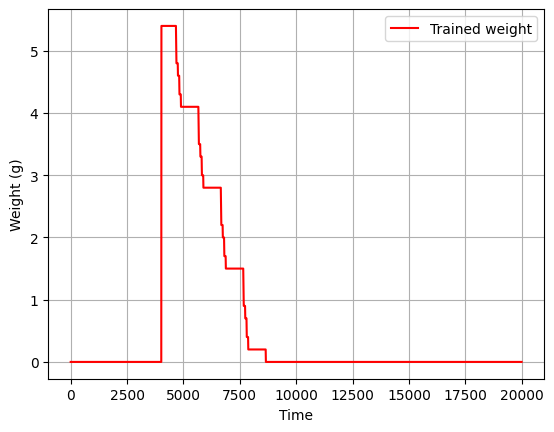

In [8]:
N=int((TMAX)//3.35) # Number of steps 
t=np.linspace(0,TMAX,N) # Timestep vector
plt.plot(t, train_g_hist[:len(t), 0, 1], color='r', label='Trained weight')
plt.ylabel('Weight (g)')
plt.xlabel('Time')
plt.legend()
plt.grid()
print("Converged weights: ", train_g_hist[len(t)-100, :, :])
plt.show()